In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from PIL import Image, ImageFile

# Pour tolérer les images tronquées
ImageFile.LOAD_TRUNCATED_IMAGES = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device: cuda


## Traitement des données médicales

Dans un premier temps, on récupère les images et leurs classes

In [2]:
data_dir = "First_Trial"

class FilteredImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Ne garder que les dossiers non vides
        classes = [
            d for d in os.listdir(directory)
            if os.path.isdir(os.path.join(directory, d))
            and len(os.listdir(os.path.join(directory, d))) > 0
        ]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

    def __getitem__(self, index):
        path, target = self.samples[index]

        try:
            img = Image.open(path).convert("RGB")  # on force en RGB directement
        except (OSError, ValueError):
            # Si l'image est corrompue → on en prend une autre au hasard
            new_index = random.randint(0, len(self.samples) - 1)
            return self.__getitem__(new_index)

        if self.transform is not None:
            img = self.transform(img)

        return img, target

On sépare ensuite les données en trois catégories (train/test/validation). Ces images et leurs labels associés sont stockés dans des dataloaders. 
On peut constater qu'on a très peu d'images. Pour résoudre ce potentiel problème, on va réaliser de la data augmentation via plusieurs transformations que l'on applique sur les images.

In [3]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
VAL_SPLIT = 0.1 #10% de val
TRAIN_SPLIT = 0.8 # 80% train / 10% test

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=IMAGE_SIZE,scale=(0.8, 1.0),ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomAffine(degrees=0,translate=(0.05, 0.05),scale=(0.95, 1.05)),
    transforms.ColorJitter(brightness=0.1,contrast=0.1,saturation=0.1,hue=0.02),
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Validation : pas d’augmentations aléatoires, juste resize + normalisation
val_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# Dataset complet pour récupérer les classes
full_dataset = FilteredImageFolder(root=data_dir, transform=train_transform)
num_classes = len(full_dataset.classes)
print("Classes :", full_dataset.classes)
print("Nombre total d'images :", len(full_dataset))

# Split train / val /test
val_size = int(VAL_SPLIT*len(full_dataset))
train_size = int(TRAIN_SPLIT*len(full_dataset))
test_size = len(full_dataset) - val_size - train_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])


val_dataset.dataset.transform = val_transform

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
)

Classes : ['HERPES SIMPLEX (112)', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']
Nombre total d'images : 1961


On visualise sur le schéma suivant le nombre d'images que l'on possède. 

Images par classe dans le train : Counter({1: 396, 4: 333, 3: 225, 7: 200, 5: 179, 2: 89, 0: 86, 6: 60})


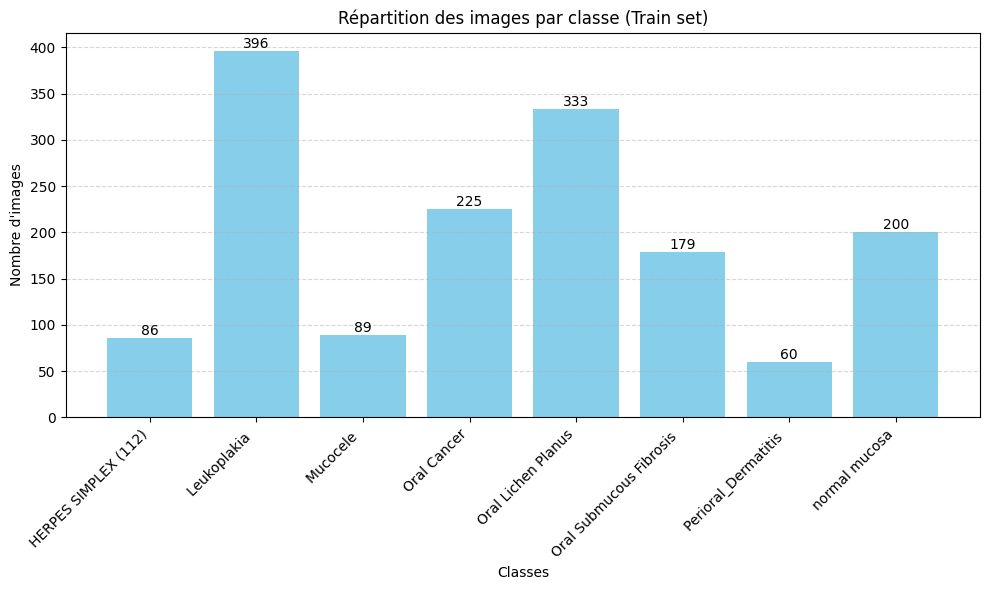

In [4]:
from collections import Counter
from torch.utils.data import WeightedRandomSampler

# Compter combien d’images par classe dans le train
targets = [full_dataset.samples[i][1] for i in train_dataset.indices]
class_counts = Counter(targets)
print("Images par classe dans le train :", class_counts)

# Poids inverses (classe rare alors poids plus grand)
num_samples = len(targets)
class_weights = {cls: num_samples / count for cls, count in class_counts.items()}
sample_weights = [class_weights[t] for t in targets]

class_counts = Counter(targets)

# Classes dans l’ordre
class_names = full_dataset.classes

# Compter selon l'ordre réel des classes
counts_ordered = [class_counts[i] if i in class_counts else 0 for i in range(len(class_names))]

plt.figure(figsize=(10, 6))
bars = plt.bar(class_names, counts_ordered, color="skyblue")

# Ajouter valeurs au-dessus de chaque barre
for bar, count in zip(bars, counts_ordered):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height(),
        str(count),
        ha='center',
        va='bottom',
        fontsize=10
    )

plt.title("Répartition des images par classe (Train set)")
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Conservation des dataloaders pour plus tard:

In [5]:
train_loader_medical = train_loader
val_loader_medical = val_loader
test_loader_medical = test_loader

## Implémentation du Vision Transformer

In [6]:
def create_mlp_block(embed_dim: int, hidden_dim: int, dropout_rate: float = 0.1):
    return nn.Sequential(
        nn.Linear(embed_dim, hidden_dim),
        nn.GELU(),
        nn.Dropout(dropout_rate),
        nn.Linear(hidden_dim, embed_dim),
        nn.Dropout(dropout_rate),
    )


In [7]:
class CreatePatchesLayer(nn.Module):
    """
    Découpe les images en patches via nn.Unfold.
    Entrée : (B, 3, H, W)
    Sortie : (B, N_patches, patch_dim) où patch_dim = P*P*3
    """

    def __init__(self, patch_size: int):
        super().__init__()
        self.patch_size = patch_size
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, C, H, W)
        B, C, H, W = x.shape

        # Vérification de la division par patch_size
        assert H % self.patch_size == 0 and W % self.patch_size == 0, \
            f"H et W doivent être multiples de patch_size={self.patch_size}, reçu H={H}, W={W}"

        patches = self.unfold(x)
        patches = patches.transpose(1, 2) # (B, N_patches, patch_dim)
        return patches

In [8]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, img_size, patch_size, embed_dim, in_channels=3):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        patch_dim = patch_size * patch_size * in_channels

        self.projection = nn.Linear(patch_dim, embed_dim)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embedding = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)

    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        B, N, _ = patches.shape
        x = self.projection(patches) # (B, N, D)
        cls_tokens = self.cls_token.expand(B, 1, -1)  # (B, 1, D)
        x = torch.cat([cls_tokens, x], dim=1) # (B, N+1, D)
        x = x + self.pos_embedding
        return x


On teste ci-dessous que l'on obtient bien les tailles souhaîtées après la transformation en Patchs et l'Embedding.

In [9]:
B, C, H, W = 2, 3, 224, 224
P = 16
D = 768

x = torch.randn(B, C, H, W)

patch_layer = CreatePatchesLayer(patch_size=P)
patches = patch_layer(x)  # (B, N_patches, P*P*C)

embed_layer = PatchEmbeddingLayer(img_size=H, patch_size=P, embed_dim=D)
out = embed_layer(patches)  # (B, N_patches+1, D)

print("patches:", patches.shape)
print("embeddings:", out.shape)


patches: torch.Size([2, 196, 768])
embeddings: torch.Size([2, 197, 768])


In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True,
            dropout=dropout
        )
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)

        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = create_mlp_block(embed_dim, hidden_dim, dropout_rate=dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.dropout1(attn_out)

        # MLP
        x_norm = self.norm2(x)
        x = x + self.mlp(x_norm)
        return x

In [11]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim: int, num_classes: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        cls_token = x[:, 0] # (B, D)
        cls_token = self.norm(cls_token)
        cls_token = self.dropout(cls_token)
        logits = self.fc(cls_token)  # (B, num_classes)
        return logits


In [12]:
class VisionTransformer(nn.Module):
    def __init__(
        self,
        img_size: int,
        patch_size: int,
        embed_dim: int,
        depth: int,
        num_heads: int,
        num_classes: int,
        mlp_ratio: float = 4.0,
        dropout: float = 0.1,
    ):
        super().__init__()

        # Patches + embedding
        self.patch_layer = CreatePatchesLayer(patch_size=patch_size)
        self.embed_layer = PatchEmbeddingLayer(
            img_size=img_size,
            patch_size=patch_size,
            embed_dim=embed_dim,
        )

        # Empilement des blocs Transformer
        self.blocks = nn.ModuleList([TransformerBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout,
            )
            for _ in range(depth)
        ])

        # Head
        self.head = ClassificationHead(
            embed_dim=embed_dim,
            num_classes=num_classes,
            dropout=dropout,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, 3, H, W)
        patches = self.patch_layer(x)
        x = self.embed_layer(patches)

        for blk in self.blocks:
            x = blk(x)

        logits = self.head(x)
        return logits


## Entraînement du modèle

In [40]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=8,
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
NUM_EPOCHS = 30

model = model.to(device)
print(model)

VisionTransformer(
  (patch_layer): CreatePatchesLayer(
    (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
  )
  (embed_layer): PatchEmbeddingLayer(
    (projection): Linear(in_features=768, out_features=256, bias=True)
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): ClassificationHead(
    (norm): LayerNorm((256,), eps=1e-05, e

In [47]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)        # (B,)
        total += batch_size
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode(): 
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)
            total += batch_size
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


Epoch [1/30] - Train loss: 1.7747, acc: 33.35% - Val loss: 1.8769, acc: 37.76%
>> Nouveau meilleur modèle sauvegardé.
Epoch [2/30] - Train loss: 1.7150, acc: 32.21% - Val loss: 1.8438, acc: 26.53%
Epoch [3/30] - Train loss: 1.6713, acc: 35.40% - Val loss: 1.6953, acc: 32.65%
Epoch [4/30] - Train loss: 1.6237, acc: 36.35% - Val loss: 1.5768, acc: 40.82%
>> Nouveau meilleur modèle sauvegardé.
Epoch [5/30] - Train loss: 1.5780, acc: 38.71% - Val loss: 1.5482, acc: 39.80%
Epoch [6/30] - Train loss: 1.5021, acc: 40.37% - Val loss: 1.4846, acc: 42.86%
>> Nouveau meilleur modèle sauvegardé.
Epoch [7/30] - Train loss: 1.4542, acc: 41.52% - Val loss: 1.5835, acc: 45.41%
>> Nouveau meilleur modèle sauvegardé.
Epoch [8/30] - Train loss: 1.4300, acc: 43.11% - Val loss: 1.4924, acc: 44.90%
Epoch [9/30] - Train loss: 1.3751, acc: 46.43% - Val loss: 1.4651, acc: 45.92%
>> Nouveau meilleur modèle sauvegardé.
Epoch [10/30] - Train loss: 1.3261, acc: 46.75% - Val loss: 1.4349, acc: 45.92%
Epoch [11/30] 

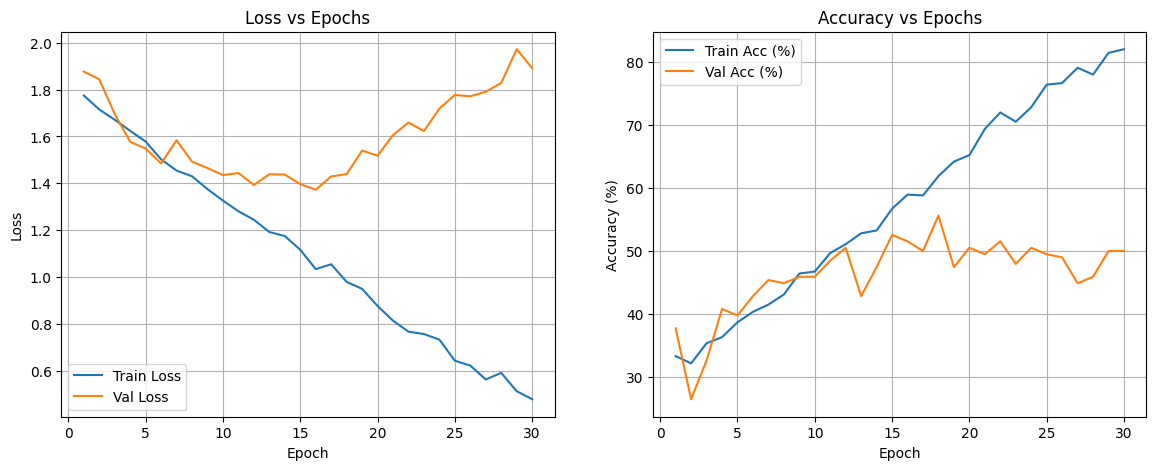

In [42]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "vit_oralyze_best.pth")
        print(">> Nouveau meilleur modèle sauvegardé.")

print(f"Meilleure val acc: {best_val_acc*100:.2f}%")


epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label="Train Acc (%)")
plt.plot(epochs, [acc * 100 for acc in val_accuracies], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

plt.show()

Ce qui pourrait apporter de meilleurs résultats: 
- On observe du sur-apprentissage -> utilisation de méthodes pour réduire le sur-apprentissage
- On remarque que la loss n'a pas fini de converger -> on peut augmenter le nombre d'epoch; Cependant on aura un entrainement très long (ici 49 min déjà)
- Le nombre de données est trop faible -> utilisation du transfert learning 

In [13]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=8,
)

model = model.to(device)
model.load_state_dict(torch.load("vit_oralyze_best.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 53.30%
Classes : ['HERPES SIMPLEX (112)', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']

--- Classification report ---
                          precision    recall  f1-score   support

    HERPES SIMPLEX (112)       0.86      0.35      0.50        17
            Leukoplakia        0.45      0.71      0.55        41
               Mucocele        0.00      0.00      0.00         9
             Oral Cancer       0.18      0.11      0.13        28
      Oral Lichen Planus       0.58      0.55      0.57        51
Oral Submucous Fibrosis        0.50      0.45      0.48        22
    Perioral_Dermatitis        0.83      1.00      0.91         5
           normal mucosa       0.86      1.00      0.92        24

                accuracy                           0.53       197
               macro avg       0.53      0.52      0.51       197
            weighted avg       0.52      0.53  

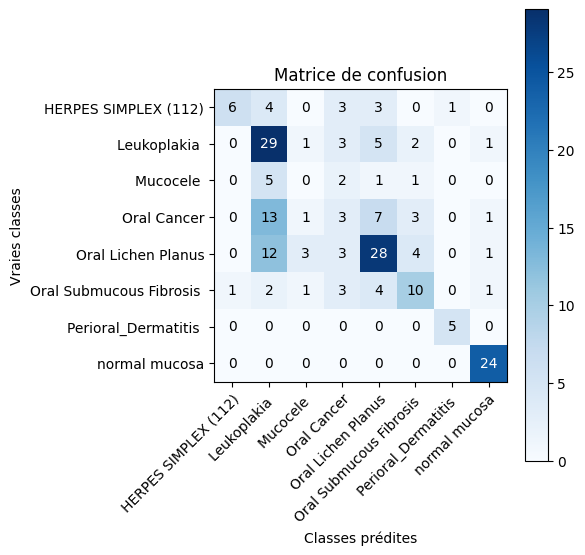

In [14]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader_medical:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

## Réduction du sur-apprentissage

On commence par réduire le sur-apprentissage sur notre base de donnée médicale.

On réduit le sur apprentissage en : 
- Utilisant DropPath
- En augmentant le DropOut

On aurait pu aussi augmenter la Data augmentation, cependant on a déjà suffisament utilisé ce principe précédemment. 

In [68]:
# Utilisation de DropPath pour réduire le surapprentissage pour les ViT
class DropPath(nn.Module):
    def __init__(self,drop_prob= None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self,x):
        if self.drop_prob ==  0 or not self.training:
            return x
        keep_prob = 1- self.drop_prob
        shape = (x.shape[0],) + (1,)*(x.ndim-1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device = x.device)
        random_tensor.floor_()
        return x/keep_prob*random_tensor

In [69]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1, droppath = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True,
            dropout=dropout # Mettre entre 0.2-0.3
        )
        self.dropout1 = nn.Dropout(dropout)

        self.drop_path = DropPath(droppath)

        self.norm2 = nn.LayerNorm(embed_dim)
        # hidden_dim = int(embed_dim * mlp_ratio)
        # self.mlp = create_mlp_block(embed_dim, [hidden_dim, embed_dim], dropout_rate=dropout)

        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = create_mlp_block(embed_dim, hidden_dim, dropout_rate=dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        #x = x + self.dropout1(attn_out) # On change cette ligne pour éviter le surapprentissage
        x = x + self.drop_path(self.dropout1(attn_out))

        # MLP
        x_norm = self.norm2(x)
        x = x + self.drop_path(self.mlp(x_norm))
        return x

In [74]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=8,
    dropout=0.25
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
NUM_EPOCHS = 30

model = model.to(device)
print(model)

VisionTransformer(
  (patch_layer): CreatePatchesLayer(
    (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
  )
  (embed_layer): PatchEmbeddingLayer(
    (projection): Linear(in_features=768, out_features=256, bias=True)
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (dropout1): Dropout(p=0.25, inplace=False)
      (drop_path): DropPath()
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.25, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.25, inplace=False)
      )
    )
  )
  (head): ClassificationHead(
    (norm

Epoch [1/30] - Train loss: 1.8209, acc: 30.87% - Val loss: 1.6886, acc: 38.27%
>> Nouveau meilleur modèle sauvegardé.
Epoch [2/30] - Train loss: 1.7193, acc: 33.48% - Val loss: 1.7495, acc: 36.73%
Epoch [3/30] - Train loss: 1.7033, acc: 33.86% - Val loss: 1.6773, acc: 34.18%
Epoch [4/30] - Train loss: 1.6797, acc: 34.69% - Val loss: 1.6490, acc: 38.27%
Epoch [5/30] - Train loss: 1.6294, acc: 36.48% - Val loss: 1.7064, acc: 38.27%
Epoch [6/30] - Train loss: 1.5823, acc: 38.01% - Val loss: 1.5691, acc: 45.41%
>> Nouveau meilleur modèle sauvegardé.
Epoch [7/30] - Train loss: 1.5698, acc: 37.18% - Val loss: 1.4976, acc: 44.90%
Epoch [8/30] - Train loss: 1.5136, acc: 39.92% - Val loss: 1.5317, acc: 41.33%
Epoch [9/30] - Train loss: 1.4717, acc: 42.16% - Val loss: 1.5081, acc: 43.88%
Epoch [10/30] - Train loss: 1.4648, acc: 41.84% - Val loss: 1.5630, acc: 42.86%
Epoch [11/30] - Train loss: 1.4622, acc: 43.56% - Val loss: 1.5235, acc: 40.31%
Epoch [12/30] - Train loss: 1.3938, acc: 45.98% - V

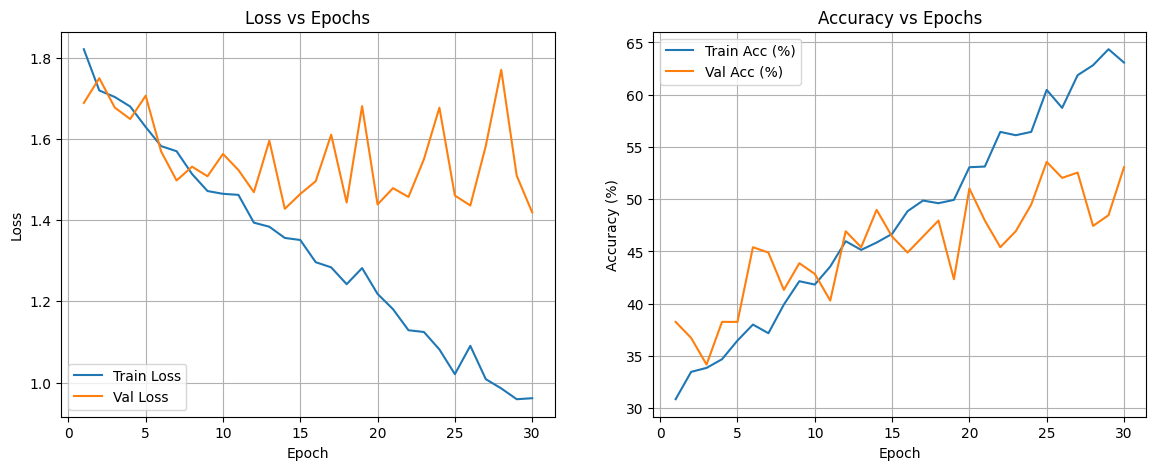

In [75]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader_medical, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader_medical, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "vit_oralyze_best_without_overfitting.pth")
        print(">> Nouveau meilleur modèle sauvegardé.")
torch.save(model.state_dict(), "vit_oralyze_without_overfitting.pth")
print(f"Meilleure val acc: {best_val_acc*100:.2f}%")


epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label="Train Acc (%)")
plt.plot(epochs, [acc * 100 for acc in val_accuracies], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

plt.show()

In [15]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=8,
    dropout=0.25
)

model = model.to(device)
model.load_state_dict(torch.load("vit_oralyze_best_without_overfitting.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 51.27%
Classes : ['HERPES SIMPLEX (112)', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']

--- Classification report ---
                          precision    recall  f1-score   support

    HERPES SIMPLEX (112)       0.53      0.47      0.50        17
            Leukoplakia        0.39      0.56      0.46        41
               Mucocele        0.33      0.11      0.17         9
             Oral Cancer       0.29      0.25      0.27        28
      Oral Lichen Planus       0.61      0.45      0.52        51
Oral Submucous Fibrosis        0.46      0.55      0.50        22
    Perioral_Dermatitis        0.56      1.00      0.71         5
           normal mucosa       0.96      0.92      0.94        24

                accuracy                           0.51       197
               macro avg       0.52      0.54      0.51       197
            weighted avg       0.52      0.51  

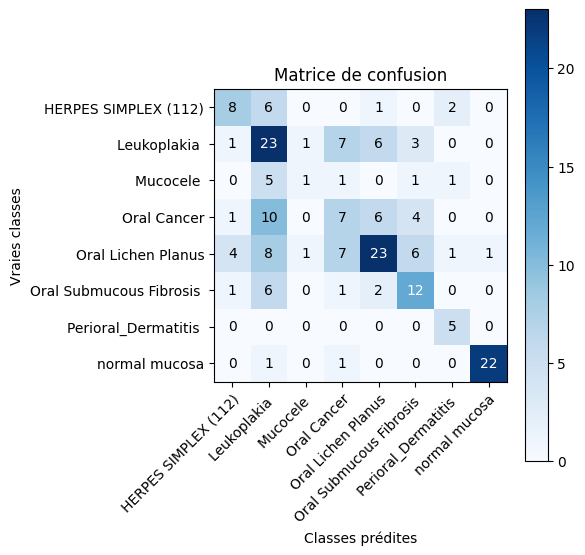

In [16]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader_medical:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

In [17]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=8,
    dropout=0.25
)

model = model.to(device)
model.load_state_dict(torch.load("vit_oralyze_without_overfitting.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 52.28%
Classes : ['HERPES SIMPLEX (112)', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']

--- Classification report ---
                          precision    recall  f1-score   support

    HERPES SIMPLEX (112)       0.70      0.41      0.52        17
            Leukoplakia        0.39      0.66      0.49        41
               Mucocele        0.40      0.22      0.29         9
             Oral Cancer       0.40      0.14      0.21        28
      Oral Lichen Planus       0.57      0.39      0.47        51
Oral Submucous Fibrosis        0.39      0.68      0.50        22
    Perioral_Dermatitis        0.83      1.00      0.91         5
           normal mucosa       0.96      0.96      0.96        24

                accuracy                           0.52       197
               macro avg       0.58      0.56      0.54       197
            weighted avg       0.55      0.52  

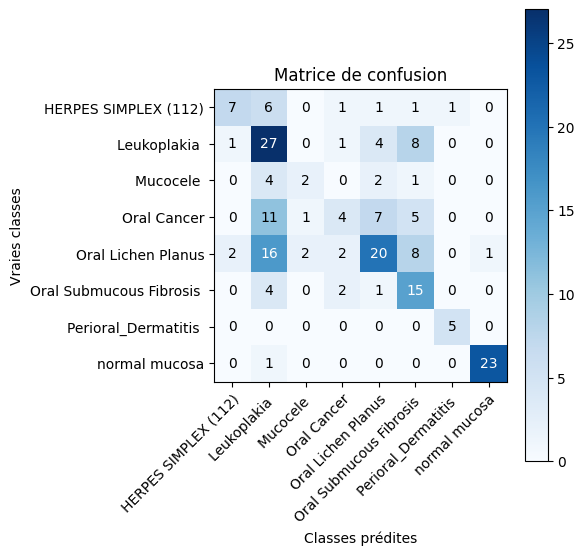

In [18]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader_medical:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

## Utilisation du transfert learning

On opte dans un deuxième temps pour la solution du transfert learning. C'est à dire, utiliser un modèle pré-entraîné en remplaçant la head, puis entrainer ce nouveau modèle sur nos données médicales. Pour ce faire, le modèle pré-entraîné sera notre modèle encodé, entraîné sur la base de données MedMNIST. On remplacera ensuite la head, puis on freeze les poids sauf ceux de la head pour entraîner le modèle sur nos données médicales.

In [19]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True,
            dropout=dropout
        )
        self.dropout1 = nn.Dropout(dropout)

        self.norm2 = nn.LayerNorm(embed_dim)

        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = create_mlp_block(embed_dim, hidden_dim, dropout_rate=dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        x = x + self.dropout1(attn_out)

        # MLP
        x_norm = self.norm2(x)
        x = x + self.mlp(x_norm)
        return x

In [20]:
from medmnist import INFO, Evaluator
import medmnist

DATASET = 'dermamnist'

info = INFO[DATASET]
n_channels = info['n_channels']
DataClass = getattr(medmnist, info['python_class'])

num_classes = len(info['label'])
print("Dataset :", DATASET)
print("Nombre de classes :", num_classes)

IMG_SIZE = 224

if n_channels == 1:
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

elif n_channels == 3:
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
else:
    raise ValueError(f"Cas non géré: n_channels={n_channels}")


train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset   = DataClass(split='val',   transform=val_transform,   download=True)


print("Nb train :", len(train_dataset))
print("Nb val   :", len(val_dataset))


test_dataset  = DataClass(split='test',  transform=val_transform,   download=True)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=4
)


Dataset : dermamnist
Nombre de classes : 7
Nb train : 7007
Nb val   : 1003


In [34]:
class_names = info['label']
print(class_names)

{'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}


In [22]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [45]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=7, #Ici on a 7 classes
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
NUM_EPOCHS = 50

model = model.to(device)
print(model)

VisionTransformer(
  (patch_layer): CreatePatchesLayer(
    (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
  )
  (embed_layer): PatchEmbeddingLayer(
    (projection): Linear(in_features=768, out_features=256, bias=True)
  )
  (blocks): ModuleList(
    (0-5): 6 x TransformerBlock(
      (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
      )
      (dropout1): Dropout(p=0.1, inplace=False)
      (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=256, out_features=1024, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.1, inplace=False)
        (3): Linear(in_features=1024, out_features=256, bias=True)
        (4): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (head): ClassificationHead(
    (norm): LayerNorm((256,), eps=1e-05, e

Adaptation des fonctions suivantes à la base de données MedNMIST 

In [46]:
def train_one_epoch_DemMnist(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device, non_blocking=True)

        labels = labels.squeeze()       # (B,1) -> (B,)
        labels = labels.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        batch_size = images.size(0)
        running_loss += loss.item() * batch_size

        preds = outputs.argmax(dim=1)
        total += batch_size
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate_DemMnist(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(device, non_blocking=True)
            labels = labels.squeeze().long().to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            batch_size = images.size(0)
            running_loss += loss.item() * batch_size

            preds = outputs.argmax(dim=1)
            total += batch_size
            correct += (preds == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


Epoch [1/50] - Train loss: 1.0262, acc: 66.12% - Val loss: 0.8943, acc: 68.69%
>> Nouveau meilleur modèle sauvegardé.
Epoch [2/50] - Train loss: 0.8745, acc: 68.26% - Val loss: 0.8175, acc: 70.49%
>> Nouveau meilleur modèle sauvegardé.
Epoch [3/50] - Train loss: 0.8218, acc: 68.80% - Val loss: 0.8051, acc: 70.19%
Epoch [4/50] - Train loss: 0.7913, acc: 70.17% - Val loss: 0.7691, acc: 71.49%
>> Nouveau meilleur modèle sauvegardé.
Epoch [5/50] - Train loss: 0.7612, acc: 71.07% - Val loss: 0.7509, acc: 72.08%
>> Nouveau meilleur modèle sauvegardé.
Epoch [6/50] - Train loss: 0.7428, acc: 71.74% - Val loss: 0.7047, acc: 73.28%
>> Nouveau meilleur modèle sauvegardé.
Epoch [7/50] - Train loss: 0.7377, acc: 72.16% - Val loss: 0.7409, acc: 72.28%
Epoch [8/50] - Train loss: 0.7155, acc: 73.00% - Val loss: 0.7051, acc: 73.18%
Epoch [9/50] - Train loss: 0.7033, acc: 72.90% - Val loss: 0.7213, acc: 71.88%
Epoch [10/50] - Train loss: 0.6996, acc: 73.54% - Val loss: 0.6999, acc: 74.68%
>> Nouveau mei

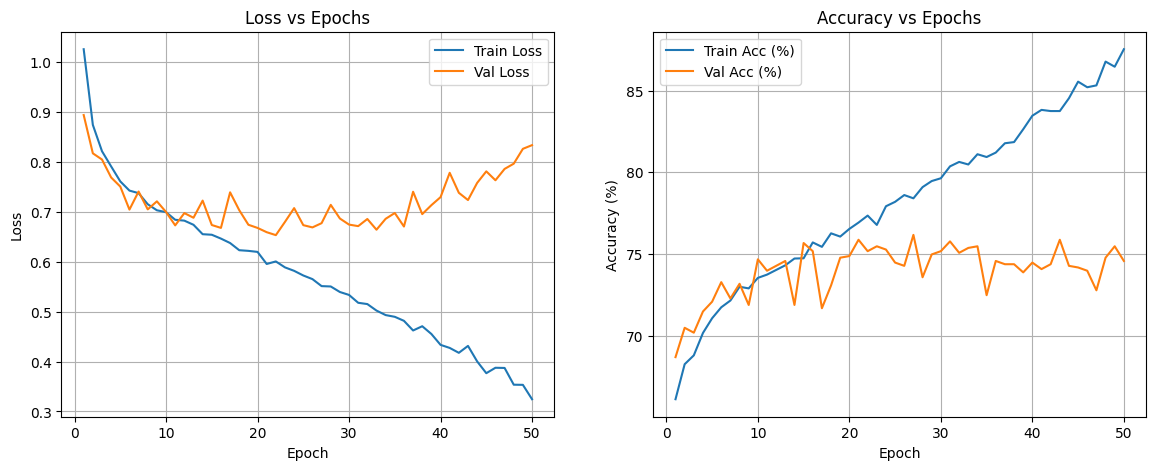

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_DemMnist(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_DemMnist(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "vit_pretrained_medmnist_best1.pth")
        print(">> Nouveau meilleur modèle sauvegardé.")

print(f"Meilleure val acc: {best_val_acc*100:.2f}%")

#Sauvegarder le model à la fin des epochs
torch.save(model.state_dict(), "vit_pretrained_medmnist1.pth")

epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label="Train Acc (%)")
plt.plot(epochs, [acc * 100 for acc in val_accuracies], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

plt.show()

On remarque dans un premier temps que l'exécution est beaucoup plus rapide (ici 21min pour 50 epoch). 

On remarque que la loss n'a pas convergé, il faut augmenter le nombre d'epoch. 

On observe également du surapprentissage

In [23]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=7, #Ici on a 7 classes
)

model = model.to(device)

model.load_state_dict(torch.load("vit_pretrained_medmnist1.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 76.11%
Classes : {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}

--- Classification report ---
              precision    recall  f1-score   support

           0       0.32      0.29      0.30        66
           1       0.42      0.56      0.48       103
           2       0.63      0.40      0.49       220
           3       0.33      0.13      0.19        23
           4       0.52      0.49      0.50       223
           5       0.86      0.92      0.89      1341
           6       0.83      0.69      0.75        29

    accuracy                           0.76      2005
   macro avg       0.56      0.50      0.51      2005
weighted avg       0.75      0.76      0.75      2005

Matrice de confusion (brute) :
 [[  19   21    9    1    4   12    0]
 [   9   58    9    1    9   16    1]
 [  13   18   87

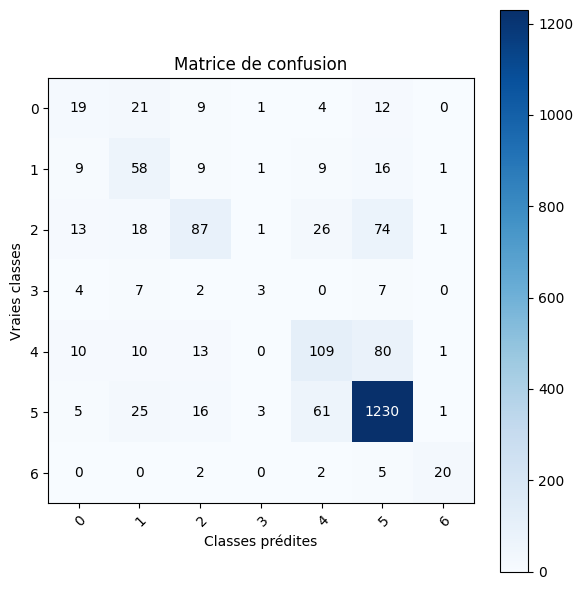

In [24]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

# class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

In [25]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=256,
    depth=6,
    num_heads=8,
    num_classes=7, #Ici on a 7 classes
)

model = model.to(device)

model.load_state_dict(torch.load("vit_pretrained_medmnist_best1.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 75.56%
Classes : {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}

--- Classification report ---
              precision    recall  f1-score   support

           0       0.37      0.33      0.35        66
           1       0.45      0.57      0.50       103
           2       0.61      0.32      0.42       220
           3       0.50      0.04      0.08        23
           4       0.53      0.36      0.43       223
           5       0.83      0.94      0.88      1341
           6       0.83      0.69      0.75        29

    accuracy                           0.76      2005
   macro avg       0.59      0.47      0.49      2005
weighted avg       0.73      0.76      0.73      2005

Matrice de confusion (brute) :
 [[  22   19    6    0    6   13    0]
 [  10   59    9    1    4   19    1]
 [  16   13   70

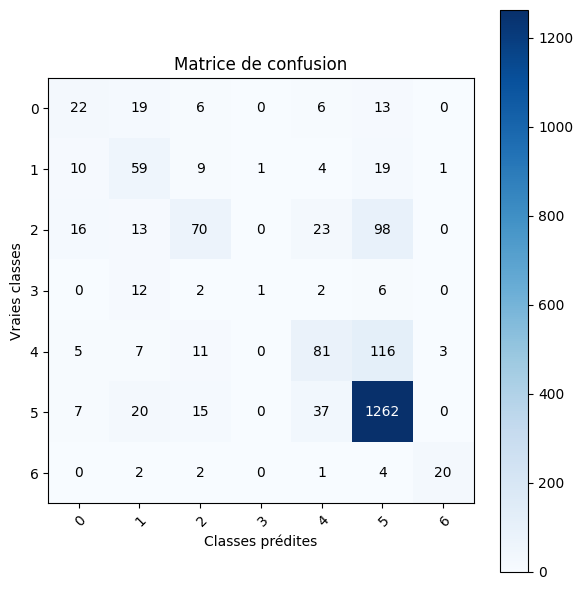

In [26]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

# class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

On observe du surapprentissage. Pour pallier à ce problème:
- Plus grande Data augmentation 
- Dropout plus fort : 0.3
- Utilisation de DropPath:0.1
- weight_decay = 0.1
- Réduire la taille du ViT avec embed_dim=128, depth=4, dropout=0.3 et mlp_ratio=2

In [48]:
# Utilisation de DropPath pour réduire le surapprentissage pour les ViT
class DropPath(nn.Module):
    def __init__(self,drop_prob= None):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self,x):
        if self.drop_prob ==  0 or not self.training:
            return x
        keep_prob = 1- self.drop_prob
        shape = (x.shape[0],) + (1,)*(x.ndim-1)
        random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device = x.device)
        random_tensor.floor_()
        return x/keep_prob*random_tensor

In [49]:
class TransformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1, droppath = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            batch_first=True,
            dropout=dropout # Mettre entre 0.2-0.3
        )
        self.dropout1 = nn.Dropout(dropout)

        self.drop_path = DropPath(droppath)

        self.norm2 = nn.LayerNorm(embed_dim)
        # hidden_dim = int(embed_dim * mlp_ratio)
        # self.mlp = create_mlp_block(embed_dim, [hidden_dim, embed_dim], dropout_rate=dropout)

        hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = create_mlp_block(embed_dim, hidden_dim, dropout_rate=dropout)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Self-attention
        x_norm = self.norm1(x)
        attn_out, _ = self.attn(x_norm, x_norm, x_norm)
        #x = x + self.dropout1(attn_out) # On change cette ligne pour éviter le surapprentissage
        x = x + self.drop_path(self.dropout1(attn_out))

        # MLP
        x_norm = self.norm2(x)
        x = x + self.drop_path(self.mlp(x_norm))
        return x

In [50]:
from medmnist import INFO, Evaluator
import medmnist


DATASET = 'dermamnist'

info = INFO[DATASET]
n_channels = info['n_channels']
DataClass = getattr(medmnist, info['python_class'])

num_classes = len(info['label'])
print("Dataset :", DATASET)
print("Nombre de classes :", num_classes)

IMG_SIZE = 224

if n_channels == 1:
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

elif n_channels == 3:
    train_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(20),
        transforms.ColorJitter(0.2,0.2,0.2,0.1),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])

    val_transform = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3),
    ])
else:
    raise ValueError(f"Cas non géré: n_channels={n_channels}")



train_dataset = DataClass(split='train', transform=train_transform, download=True)
val_dataset   = DataClass(split='val',   transform=val_transform,   download=True)


print("Nb train :", len(train_dataset))
print("Nb val   :", len(val_dataset))
print("Nb test  :", len(test_dataset))


Dataset : dermamnist
Nombre de classes : 7
Nb train : 7007
Nb val   : 1003
Nb test  : 197


In [51]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [54]:
model = VisionTransformer( #Réduction du model
    img_size=224,
    patch_size=16,
    embed_dim=128,
    depth=4,
    num_heads=8,
    num_classes=7,#Ici on a 7 classes
    dropout=0.3,
    mlp_ratio=2
)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1) # Changement de weight_decay
NUM_EPOCHS = 100

model = model.to(device)
print(model)

VisionTransformer(
  (patch_layer): CreatePatchesLayer(
    (unfold): Unfold(kernel_size=16, dilation=1, padding=0, stride=16)
  )
  (embed_layer): PatchEmbeddingLayer(
    (projection): Linear(in_features=768, out_features=128, bias=True)
  )
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (dropout1): Dropout(p=0.3, inplace=False)
      (drop_path): DropPath()
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=256, bias=True)
        (1): GELU(approximate='none')
        (2): Dropout(p=0.3, inplace=False)
        (3): Linear(in_features=256, out_features=128, bias=True)
        (4): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (head): ClassificationHead(
    (norm): La

Epoch [1/100] - Train loss: 1.1440, acc: 65.58% - Val loss: 1.0040, acc: 67.60%
>> Nouveau meilleur modèle sauvegardé.
Epoch [2/100] - Train loss: 1.0572, acc: 65.91% - Val loss: 0.9571, acc: 67.50%
Epoch [3/100] - Train loss: 1.0211, acc: 66.68% - Val loss: 0.9806, acc: 67.60%
Epoch [4/100] - Train loss: 0.9970, acc: 66.32% - Val loss: 0.9751, acc: 67.40%
Epoch [5/100] - Train loss: 0.9704, acc: 67.40% - Val loss: 0.9535, acc: 67.00%
Epoch [6/100] - Train loss: 0.9642, acc: 67.40% - Val loss: 0.9359, acc: 67.60%
Epoch [7/100] - Train loss: 0.9437, acc: 67.79% - Val loss: 0.8899, acc: 67.60%
Epoch [8/100] - Train loss: 0.9338, acc: 67.99% - Val loss: 1.0080, acc: 68.20%
>> Nouveau meilleur modèle sauvegardé.
Epoch [9/100] - Train loss: 0.9229, acc: 67.86% - Val loss: 0.8285, acc: 69.99%
>> Nouveau meilleur modèle sauvegardé.
Epoch [10/100] - Train loss: 0.9228, acc: 67.89% - Val loss: 0.9382, acc: 68.30%
Epoch [11/100] - Train loss: 0.9010, acc: 68.39% - Val loss: 0.8720, acc: 68.20%
E

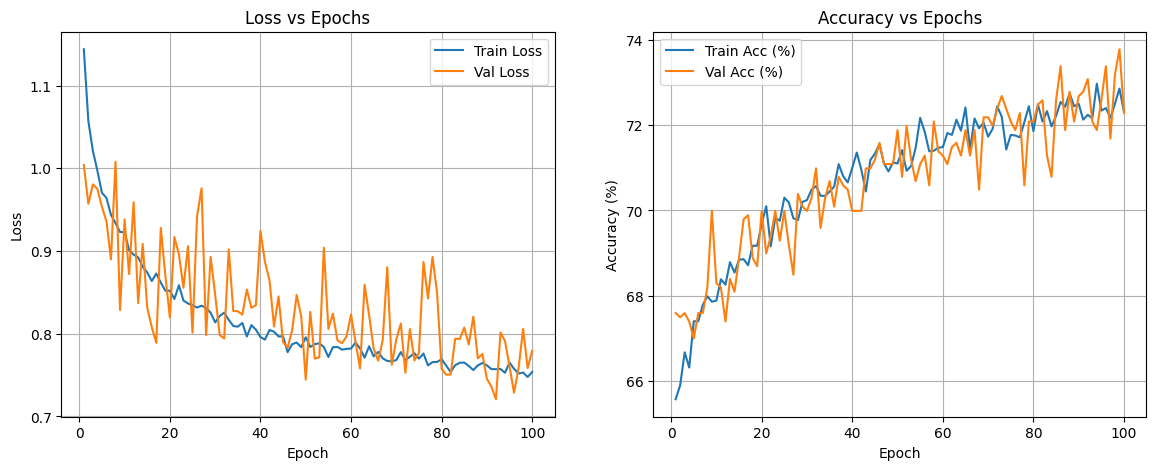

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch_DemMnist(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate_DemMnist(model, val_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "vit_pretrained_medmnist_best2.pth")
        print(">> Nouveau meilleur modèle sauvegardé.")

print(f"Meilleure val acc: {best_val_acc*100:.2f}%")

#Sauvegarder le model à la fin des epochs
torch.save(model.state_dict(), "vit_pretrained_medmnist2.pth")


epochs = range(1, NUM_EPOCHS + 1)

plt.figure(figsize=(14, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(epochs, [acc * 100 for acc in train_accuracies], label="Train Acc (%)")
plt.plot(epochs, [acc * 100 for acc in val_accuracies], label="Val Acc (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs Epochs")
plt.legend()
plt.grid(True)

plt.show()

On charge le modèle entraîné précédemment et on teste sur nos données de test.

In [43]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=128,
    depth=4,
    num_heads=8,
    num_classes=7,
    mlp_ratio=2
)

model = model.to(device)

model.load_state_dict(torch.load("vit_pretrained_medmnist2.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 71.97%
Classes : {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}

--- Classification report ---
              precision    recall  f1-score   support

           0       0.20      0.05      0.07        66
           1       0.62      0.23      0.34       103
           2       0.49      0.20      0.28       220
           3       0.00      0.00      0.00        23
           4       0.42      0.39      0.41       223
           5       0.78      0.95      0.85      1341
           6       0.73      0.55      0.63        29

    accuracy                           0.72      2005
   macro avg       0.46      0.34      0.37      2005
weighted avg       0.67      0.72      0.68      2005

Matrice de confusion (brute) :
 [[   3    8    9    0    6   40    0]
 [   6   24   10    0   13   49    1]
 [   4    1   44

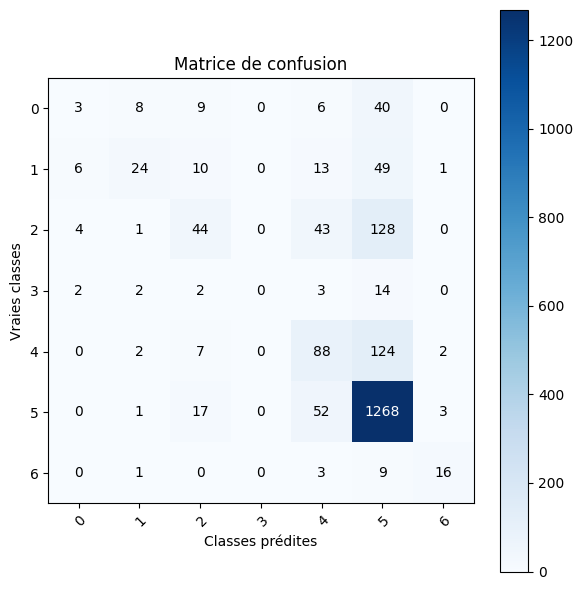

In [44]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

# class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()

On remplace la head et on freeze les paramètres du modèle précédent.

In [37]:
class ClassificationHead(nn.Module):
    def __init__(self, embed_dim: int, num_classes: int, dropout: float = 0.1):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x : (B, N+1, D)
        cls = x[:, 0]              # (B, D)
        cls = self.norm(cls)
        cls = self.dropout(cls)
        logits = self.fc(cls)      # (B, num_classes)
        return logits


# Remplacer la head
model.head = ClassificationHead(embed_dim=128, num_classes=8).to(device) #On revient ici à 8 classes

In [38]:
for name, param in model.named_parameters():
    if "head" not in name:
        param.requires_grad = False

for name, param in model.named_parameters():
    print(name, param.requires_grad)

embed_layer.cls_token False
embed_layer.pos_embedding False
embed_layer.projection.weight False
embed_layer.projection.bias False
blocks.0.norm1.weight False
blocks.0.norm1.bias False
blocks.0.attn.in_proj_weight False
blocks.0.attn.in_proj_bias False
blocks.0.attn.out_proj.weight False
blocks.0.attn.out_proj.bias False
blocks.0.norm2.weight False
blocks.0.norm2.bias False
blocks.0.mlp.0.weight False
blocks.0.mlp.0.bias False
blocks.0.mlp.3.weight False
blocks.0.mlp.3.bias False
blocks.1.norm1.weight False
blocks.1.norm1.bias False
blocks.1.attn.in_proj_weight False
blocks.1.attn.in_proj_bias False
blocks.1.attn.out_proj.weight False
blocks.1.attn.out_proj.bias False
blocks.1.norm2.weight False
blocks.1.norm2.bias False
blocks.1.mlp.0.weight False
blocks.1.mlp.0.bias False
blocks.1.mlp.3.weight False
blocks.1.mlp.3.bias False
blocks.2.norm1.weight False
blocks.2.norm1.bias False
blocks.2.attn.in_proj_weight False
blocks.2.attn.in_proj_bias False
blocks.2.attn.out_proj.weight False
bloc

On augment le learning rate pour mieux apprendre nos données.

In [48]:
optimizer = torch.optim.AdamW(
    model.head.parameters(),
    lr=1e-2,
    weight_decay=0.0
)

criterion = nn.CrossEntropyLoss()
NUM_EPOCHS = 10

In [67]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

best_val_acc = 0.0

for epoch in range(1, NUM_EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader_medical, optimizer, criterion, device)
    val_loss, val_acc     = evaluate(model, val_loader_medical, criterion, device)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    
    
    print(
        f"Epoch [{epoch}/{NUM_EPOCHS}] "
        f"- Train loss: {train_loss:.4f}, acc: {train_acc*100:.2f}% "
        f"- Val loss: {val_loss:.4f}, acc: {val_acc*100:.2f}%"
    )

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "vit_oralyze_best_transfert_learning.pth")
        print(">> Nouveau meilleur modèle sauvegardé.")
torch.save(model.state_dict(), "vit_oralyze_transfert_learning.pth")
print(f"\nMeilleure val acc: {best_val_acc*100:.2f}%")


Epoch [1/10] - Train loss: 1.7996, acc: 32.46% - Val loss: 1.7474, acc: 42.86%
>> Nouveau meilleur modèle sauvegardé.
Epoch [2/10] - Train loss: 1.6756, acc: 36.54% - Val loss: 1.6498, acc: 40.82%
Epoch [3/10] - Train loss: 1.6311, acc: 37.12% - Val loss: 1.6581, acc: 36.73%
Epoch [4/10] - Train loss: 1.6052, acc: 37.50% - Val loss: 1.6670, acc: 40.31%
Epoch [5/10] - Train loss: 1.5948, acc: 39.41% - Val loss: 1.6410, acc: 36.22%
Epoch [6/10] - Train loss: 1.6010, acc: 38.58% - Val loss: 1.6566, acc: 36.73%
Epoch [7/10] - Train loss: 1.5631, acc: 39.35% - Val loss: 1.6127, acc: 39.80%
Epoch [8/10] - Train loss: 1.5770, acc: 38.58% - Val loss: 1.6082, acc: 42.86%
Epoch [9/10] - Train loss: 1.5687, acc: 38.84% - Val loss: 1.6251, acc: 44.90%
>> Nouveau meilleur modèle sauvegardé.
Epoch [10/10] - Train loss: 1.5603, acc: 39.86% - Val loss: 1.6147, acc: 46.43%
>> Nouveau meilleur modèle sauvegardé.

Meilleure val acc: 46.43%


On observe que la loss n'a pas encore convergé mais on obtient une accuracy plutôt acceptable pour le nombre d'epoch. 

Pour améliorer ce modèle, il faudrait:
- Augmenter le nombre d'epoch 
- Trouver une base de données plus adaptée que MedMNIST pour le pré-entrainement

In [ ]:
model = VisionTransformer(
    img_size=224,
    patch_size=16,
    embed_dim=128,
    depth=4,
    num_heads=8,
    num_classes=8, #Ici 8 classes
    mlp_ratio=2
)

model = model.to(device)

model.load_state_dict(torch.load("vit_oralyze_transfert_learning.pth"), strict=False)

<All keys matched successfully>


Test accuracy : 45.69%
Classes : ['HERPES SIMPLEX (112)', 'Leukoplakia ', 'Mucocele ', 'Oral Cancer', 'Oral Lichen Planus', 'Oral Submucous Fibrosis ', 'Perioral_Dermatitis ', 'normal mucosa']

--- Classification report ---
                          precision    recall  f1-score   support

    HERPES SIMPLEX (112)       0.40      0.24      0.30        17
            Leukoplakia        0.36      0.73      0.48        41
               Mucocele        0.00      0.00      0.00         9
             Oral Cancer       0.20      0.04      0.06        28
      Oral Lichen Planus       0.45      0.53      0.49        51
Oral Submucous Fibrosis        0.75      0.14      0.23        22
    Perioral_Dermatitis        1.00      0.40      0.57         5
           normal mucosa       0.72      0.96      0.82        24

                accuracy                           0.46       197
               macro avg       0.48      0.38      0.37       197
            weighted avg       0.45      0.46  

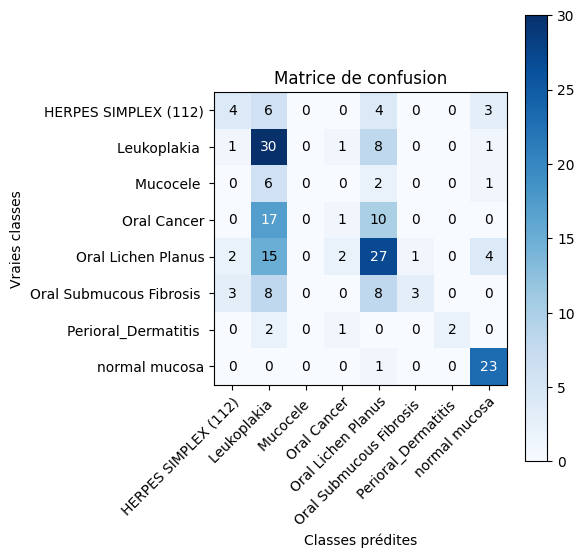

In [31]:
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader_medical:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

test_accuracy = accuracy_score(all_labels,all_preds)
print(f'\nTest accuracy : {test_accuracy*100:.2f}%')

class_names = full_dataset.classes
print("Classes :", class_names)

print('\n--- Classification report ---')
report = classification_report(all_labels,all_preds,target_names=class_names,zero_division=0)
print(report)

cm = confusion_matrix(all_labels, all_preds)
print("Matrice de confusion (brute) :\n", cm)

fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(cm, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(class_names)),
    yticks=np.arange(len(class_names)),
    xticklabels=class_names,
    yticklabels=class_names,
    ylabel='Vraies classes',
    xlabel='Classes prédites',
    title='Matrice de confusion'
)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

# annotations dans chaque case
thresh = cm.max() / 2.0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()